![](https://i.imgur.com/qrtlqTe.png)

# Introduction to this Notebook

Approaching the EEG Fuzzy Logic and trying/ comparing various methods regarding the various techniques of the pipeline.

### Goal

Creating a general pipeline that will data real time eeg recordings and classifies the mental state of the person using it.
The main innovations:
* -> keep the process extra simple and easy for the user
* -> applying best mathematical and ML methods for the best result
* -> test it in an already existing system/ app : Neurofusion
* -> gather everything and providing a product/ feature

### Pipeline
proper eeg recordings/ Data colelction based on both the hardware and the astrobird game -> Gathering correct data format and extracting chunks of interest based on the timestamps of the game -> Signal Denoise -> Feature Extraction -> Data Description / information of interest -> Classifing the state 

### Notes

![](https://cdn-icons-png.flaticon.com/256/3800/3800406.png)


This Notebook will be based on the really helpful paper:
Md. Mustafizur Rahman, Ajay Krishno Sarkar, Md. Amzad Hossain, Md. Selim Hossain, Md. Rabiul Islam, Md. Biplob Hossain, Julian M.W. Quinn, Mohammad Ali Moni,
Recognition of human emotions using EEG signals: A review,
Computers in Biology and Medicine,
Volume 136,
2021,
104696,
ISSN 0010-4825,
https://doi.org/10.1016/j.compbiomed.2021.104696.
(https://www.sciencedirect.com/science/article/pii/S001048252100490X)
*Abstract: Assessment of the cognitive functions and state of clinical subjects is an important aspect of e-health care delivery, and in the development of novel human-machine interfaces. A subject can display a range of emotions that significantly influence cognition, and emotion classification through the analysis of physiological signals is a key means of detecting emotion. Electroencephalography (EEG) signals have become a common focus of such development compared to other physiological signals because EEG employs simple and subject-acceptable methods for obtaining data that can be used for emotion analysis. We have therefore reviewed published studies that have used EEG signal data to identify possible interconnections between emotion and brain activity. We then describe theoretical conceptualization of basic emotions, and interpret the prevailing techniques that have been adopted for feature extraction, selection, and classification. Finally, we have compared the outcomes of these recent studies and discussed the likely future directions and main challenges for researchers developing EEG-based emotion analysis methods.


### Here I am going to visualise, get familiar, clean and analyse the final data collected and the dictionary with the epochs created by Ilia and Aman in Myelin's Hacker House/ June 2023.


## About the data acquisition 

![](https://media.licdn.com/dms/image/C560BAQHAvDDmK6yunw/company-logo_200_200/0/1519884058340?e=2147483647&v=beta&t=422BH8vOzT7W8TKoXfvMXEQcdY8TNISZ3w2Qy4uOKXs)


# EEG Data Recording

Used Mentalab's headset Explore+ 
* https://mentalab.com/


*5.4. EEG electrodes Usually EEG devices record brain signals using electrodes over the scalp according to the 10/20 methodology. Sometimes maintaining so many electrodes may be difficult for the users, and this makes the systems complex. Therefore, the number of electrodes must be kept low to avoid system difficulty. It is for this reason that the electrode numbers used in the studies ranged from 2 to 62. Only 17% of the studies (9 out of 54) used less than 12 electrodes, while 13% of studies (7 works out of 54) used 14 electrodes. One study [81] found that the most reliable electrode positions for detecting emotional valence are F3 and F4. Valenzi et al. [82] had used eight electrodes to classify the emotion and obtained an accuracy of 87.5%. Another two articles [52,58] recorded EEG signals using only one electrode, while article [83] utilized three channels to detect the signal. S. Wu et al. [56] utilized two channels, Fp1 and Fp2, to detect emotions and obtained an accuracy of 76.34%. About 41% of the studies (22 out of 54) utilized 32 electrodes to record the EEG signal in the past studies. Moreover, 24% of the studies (13 out of 54) used 62 electrodes; two studies utilized 40 and 60 electrodes, respectively (see Fig. 7).* 


We are using 8 channels:

**CP3, C3 F5, PO3, PO4, F6, C4, CP4**

![](https://i.imgur.com/6VPj2Jz.png)

**Sample Freq:** 256 Hz

**Channels Used:**  C3, CP3, P3, P4, C4, F4, CP4, F5



![](https://media.discordapp.net/attachments/1107723057675645121/1115625454406213652/IMG_20230603_153825.jpg?width=862&height=645)

## About the method to get the emotions in time accuracy 
For the binary classficiation of the emotional state to train a model we used flappy bird as described more Myelin's Hacker House blog here: https://myelin.substack.com/p/fuzzy-logic-and-flappy-bird?sd=pf

![](https://images-ext-1.discordapp.net/external/6LliJIqDr2WTN6LI2LCsgsJsIhACDfKRnMYxPHufpTU/https/codesandbox.io/api/v1/sandboxes/h2h00z/screenshot.png)

## About the baseline binary group of events / epochs selection and form of dictionary - data structure - 

### Disclaimer
> **We have decided to test the data and the classification algorithms on a extremely easy set ...
>  the data is not enough / not 100% clean proffesionally collected and the 2 states of classification not ideal but we are focusing on that more for creating the important pipeline which will be the same for any other eeg emotion state classification and open source. ****

### Dictionary of epochs stucture


**Duration of epochs:** 4 seconds  ( that can be changed )

**Labels** Two states out of the game:
1) **neutral**: any event after 2 and before 2 seconds from start and end of game session/ focused without feelings
2) **end**:  2 seconds before losing and 2 seconds after restarting the new game session. anticipation/ sadness/ stress/ dissapointment

![](https://media.discordapp.net/attachments/1102775621991530510/1117173936887697518/image.png?width=915&height=645)






Let's load the code the guy's wrote for creating the dictionary containg the data we want...


In [18]:
# Load Libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class DataAnalysis():
    def __init__(self, path_EEG, path_FlappyBird, window_size_sec, UNIX, LSL):
        self.df_E = pd.read_csv(path_EEG)
        self.df_F = pd.read_csv(path_FlappyBird)
        self.channels = pd.read_csv(path_EEG).columns[1:]
        print(self.channels)
        self.window = window_size_sec
        self.offset = UNIX - LSL
        self.df_E = self.df_E.rename(columns={"TimeStamp": "Timestamp"})
        self.df_E['Timestamp'] = (self.df_E['Timestamp']*1000).astype('int') + self.offset
    
    def find_nearest(self, array, value):
        array = np.asarray(array)
        value_true = array[(np.abs(array - value)).argmin()]
        return value_true
        
    def dataframe_of_events_and_merge(self):
        #This function gets the timestamps of all events Start and Over 
        df = self.df_E.merge(self.df_F, on='Timestamp', how='outer')
        df = df.sort_values(by="Timestamp").reset_index()
        event_rows = df[(df.Event == 'Start') | (df.Event == 'Over')].index
        return df.iloc[event_rows], df
    
    def get_window(self, timestamp):
        window_df = pd.DataFrame()
        lower = timestamp - self.window * 1000
        upper = timestamp + self.window * 1000
        window_df = self.df_E[(self.df_E.Timestamp >= lower) & (self.df_E.Timestamp <= upper)]
        return window_df
    
    def plot_window(self, event_number):
        events_df, df = self.dataframe_of_events_and_merge()
        timestamp = events_df.iloc[event_number].Timestamp
        window_df = self.get_window(timestamp)
        for channel in self.channels:
            window_array = window_df[channel]
            plt.plot(window_df.Timestamp, window_array, color='red')
            plt.title("Node:" + channel)
            plt.plot(np.ones(1000)*events_df.iloc[event_number]['Timestamp'], np.linspace(min(window_array), max(window_array), 1000))
            plt.grid()
            plt.tight_layout()
            plt.show()
            
    def get_analysis_timestamps(self):
        events_df, df = self.dataframe_of_events_and_merge()
        window_adj = self.window*2
        dictionary = {'neutral':[], 'end':[]}
        events = events_df['Timestamp'].to_numpy()
        # Getting the timestamps of events we need
        for i in range(0, len(events_df), 2):
            time = (events[i+1] - events[i])/1000
            if time > window_adj:
                dictionary['end'].append(events[i+1])
            if time > window_adj*2 and time < 45:
                counter = 1
                while events[i] + window_adj*counter*1000 < events[i+1]:
                    dictionary['neutral'].append(events[i] + window_adj*counter*1000)
                    counter+=1
                    
        #If there's no timestamp corresponding to neutral one exactly, we find the nearest one
        true_array = []
        for element in dictionary['neutral']:
            true_array.append(self.find_nearest(self.df_E['Timestamp'].to_numpy(), element))
        dictionary['neutral'] = true_array
#         dictionary['end'] = list(dictionary['end'])
        #we replace each element of dictionary with 2-d array of size 9*n
        for i in range(len(dictionary['end'])):
            dictionary['end'][i] = self.get_window(dictionary['end'][i]).to_numpy()
        for j in range(len(dictionary['neutral'])):
            dictionary['neutral'][j] = self.get_window(dictionary['neutral'][j]).to_numpy()
        return dictionary        

Data that is uploaded on Myelin's Github Rep

In [20]:
# Sourcing our recorded data, df_f = flappy bird trials, df_e = eeg recordings
df_f1 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_1/FlappyB_1.csv"
df_f2 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_2/FlappyB_2.csv"
df_f3 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_3/FlappyB_3.csv"
df_f4 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_4/FlappyB_4.csv"
df_f5 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_5/FlappyB_5.csv"
df_f6 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_6/FlappyB_6.csv"
df_f7 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_7/FlappyB_7.csv"
df_f8 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_8/FlappyB_8.csv"
df_f9 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_9/FlappyB_9.csv"


df_e1 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_1/FlappyBird_Trial_1_ExG.csv"
df_e2 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_2/FlappyBird_Trial_2_ExG.csv"
df_e3 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_3/FlappyBird_Trial_3_ExG.csv"
df_e4 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_4/FlappyBird_Trial_4_ExG.csv"
df_e5 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_5/FlappyBird_Trial_5_ExG.csv"
df_e6 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_6/FlappyBird_Trial_6_ExG.csv"
df_e7 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_7/FlappyBird_Trial_7_ExG.csv"
df_e8 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_8/FlappyBird_Trial_8_ExG.csv"
df_e9 = "https://raw.githubusercontent.com/MyelinGroup/myelin-fuzzy-logic/main/Our%20Recorded%20Data/FlappyBird_Trial_9/FlappyBird_Trial_9_ExG.csv"


Create the dictionary based on recording number 5

Index(['c3', 'cp3', 'po3', 'p4', 'c4', 'f4', 'cp4', 'f5'], dtype='object')


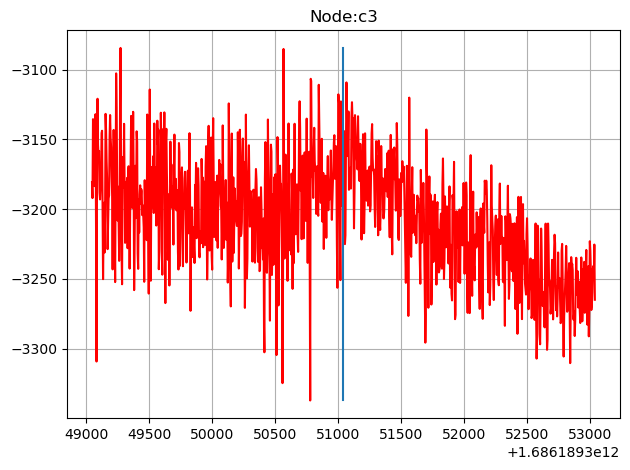

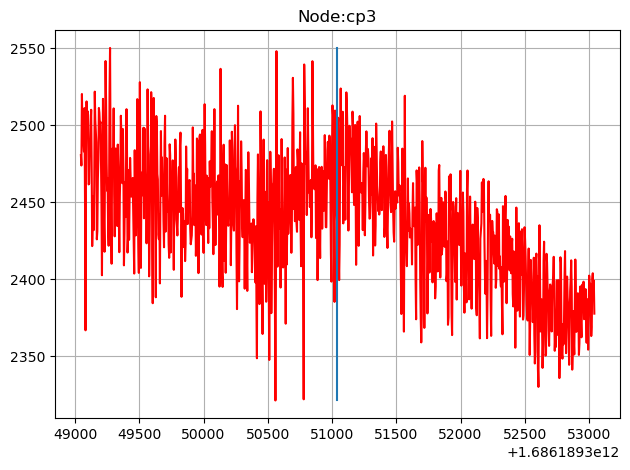

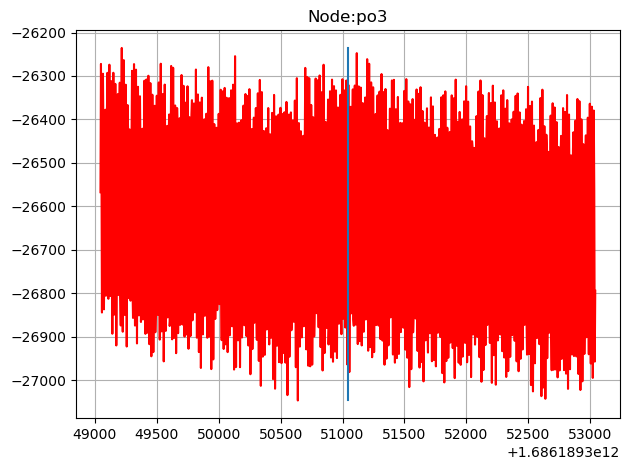

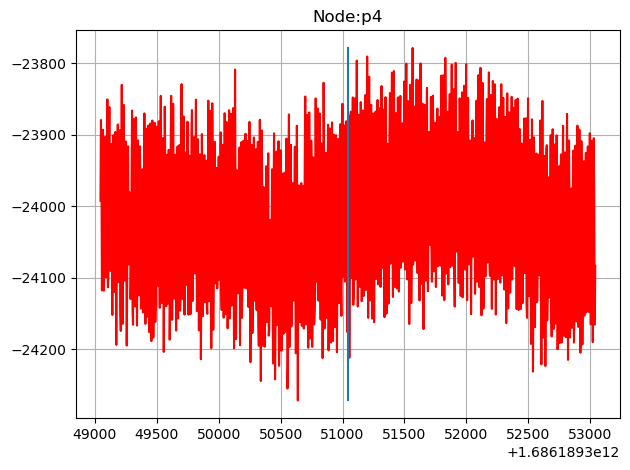

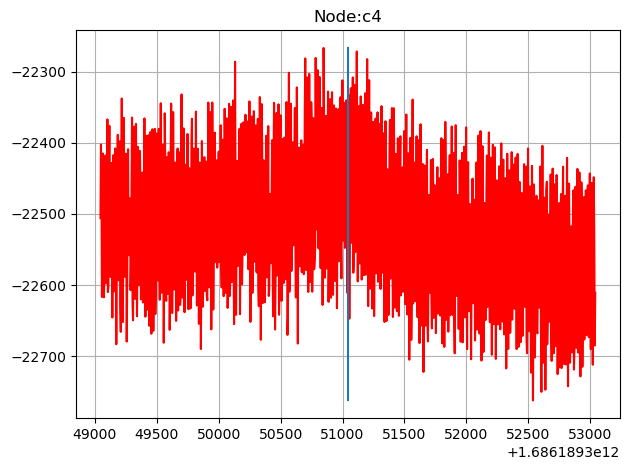

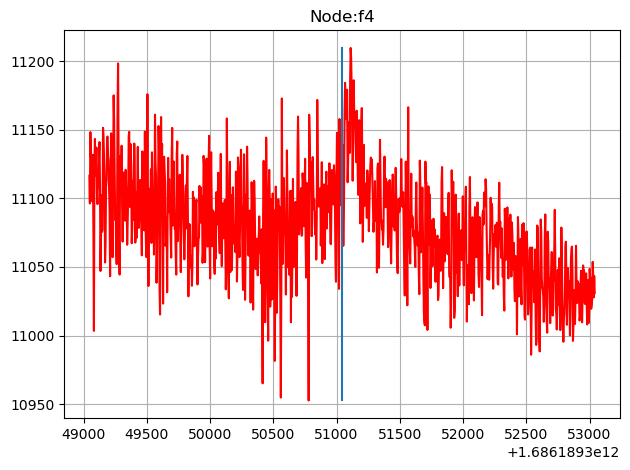

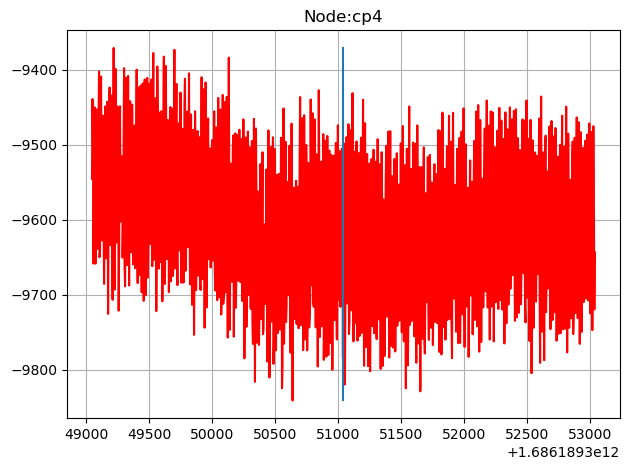

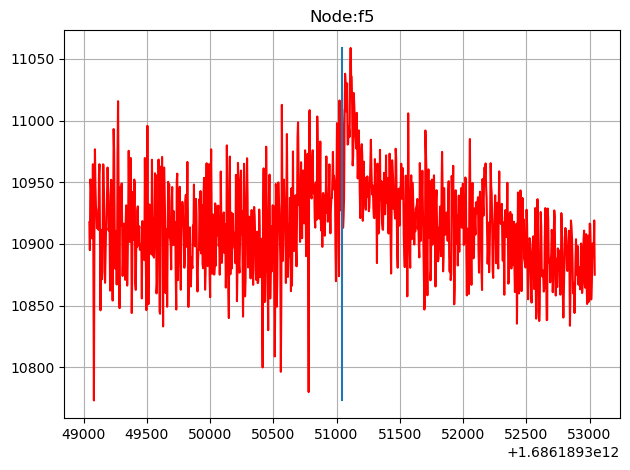

In [21]:
# timestmaps for rec 5 (1686490572615, 2453683) got it from timestamps_trial_5.txt file github of specifci recoridng folder
# timestamps for rec 4 (1686490104157, 1985220)    >> >>  >>         >>

# timestamps for rec 2 ((1686188325437, 943743)    >> >>  >>         >>  1686188325437, 943743

             # Recording 2 might be the best one so far so were gonna work on that
    
time_window= 2       # 2 sec before + 2 seconds after = 4 seconds total 

model = DataAnalysis(df_e2, df_f2, time_window, 1686188325437, 943743)  



print(model)

model.plot_window(11)

## Understanding the data we have in our hands
![](https://i.imgur.com/4pk6732.png)

In [22]:


# UNDERSTAND THE DATA

neutral=model.get_analysis_timestamps()['neutral'] #,dtype=object)
end=model.get_analysis_timestamps()['end']


print(len(neutral))

print(len(end))


one_event = neutral[11]

print(one_event.shape)
print(one_event)







34
29
(1001, 9)
[[ 1.6861894e+12 -3.4623200e+03  2.1105300e+03 ...  1.0858920e+04
  -8.4676300e+03  1.0831170e+04]
 [ 1.6861894e+12 -3.4900700e+03  2.0595100e+03 ...  1.0802990e+04
  -8.7125800e+03  1.0814570e+04]
 [ 1.6861894e+12 -3.5336500e+03  2.0126300e+03 ...  1.0749820e+04
  -8.8563000e+03  1.0769560e+04]
 ...
 [ 1.6861894e+12 -3.5543000e+03  1.9755400e+03 ...  1.0719680e+04
  -8.9152800e+03  1.0782390e+04]
 [ 1.6861894e+12 -3.5751300e+03  1.9704300e+03 ...  1.0712100e+04
  -8.7904900e+03  1.0756300e+04]
 [ 1.6861894e+12 -3.6449400e+03  1.9138800e+03 ...  1.0667950e+04
  -8.6904500e+03  1.0674530e+04]]


In [23]:
###              Let's make it more readable to the human eye so it makes sense

df = pd.DataFrame(one_event)
df = pd.DataFrame(one_event, columns=['Timestamps','C3', 'CP3','P3','P4',' C4', 'F4', 'CP4','F5'])
print(df)

        Timestamps       C3      CP3        P3        P4        C4        F4  \
0     1.686189e+12 -3462.32  2110.53 -26519.54 -23905.71 -22706.65  10858.92   
1     1.686189e+12 -3490.07  2059.51 -26972.39 -24164.58 -22946.79  10802.99   
2     1.686189e+12 -3533.65  2012.63 -27228.31 -24308.54 -23084.79  10749.82   
3     1.686189e+12 -3465.56  2104.38 -26828.15 -24058.34 -22844.36  10851.58   
4     1.686189e+12 -3503.32  2076.67 -26566.60 -23961.45 -22755.63  10800.89   
...            ...      ...      ...       ...       ...       ...       ...   
996   1.686189e+12 -3613.28  1947.83 -26618.01 -24075.32 -22779.80  10710.62   
997   1.686189e+12 -3596.16  1944.88 -26954.27 -24252.70 -22940.69  10699.61   
998   1.686189e+12 -3554.30  1975.54 -27226.64 -24374.11 -23054.65  10719.68   
999   1.686189e+12 -3575.13  1970.43 -26958.52 -24239.11 -22933.77  10712.10   
1000  1.686189e+12 -3644.94  1913.88 -26673.51 -24131.92 -22837.83  10667.95   

          CP4        F5  
0    -8467.63

<Axes: xlabel='Timestamps'>

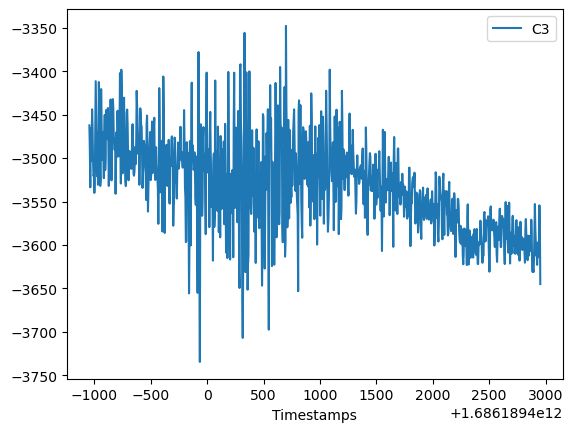

In [24]:
df.plot(x='Timestamps', y='C3')  #, kind='scatter')

ok seems correct with the plot windows so now we are confident of where the data is and we can move on

We have to choose the optimal channel for the classification...
the above code filters in a ctuoff of freq= 60 hz but doesnt handle other artifacts such as muscle moveents, eye blinks, electrode dysplacement etc.
We can visualise for example bellow channels , to understnad the difference between a good and a bad signal recording.
![](https://www.intechopen.com/media/chapter/54606/media/F2.png)


Cleaning an EEG signal is complex but we can minimise the noise..
methods used could be:

- filtering on certian freq (already done above) 
- threshold for spefific amplitude muscle movements
- wavelets when you know the shape of the noise you expect or NN on them for example eye blinks
- Independent Component Analysis (ICA) method used to separate mixed signals into their underlying independent component
- Other metrics such as standad deviation to see how far are distributed the points of the signal. Remember though that in eeg we expect them to not be so close3 to each other as they are time series biosignals, and also a small std could mean that it is puely noise..so we have to take care of a threshold in that case.




> ****One more thing we should point out is that we want to create a BCI app for well-being and fun. So we care about the analogy of the signal and not the actual form that is crucial for medical devices and clinical diagnosis**

### let's filter first of all between freq of interest 0.1 to 60 Hz would be fine for normal Human EEG
![](https://www.daviddarling.info/images_music/bandpass_filter.gif)

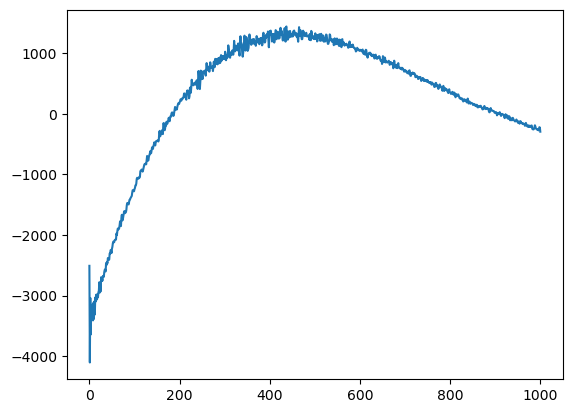

In [25]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtered = butter_bandpass_filter(df['C3'], 0.1, 120, 256)

plt.plot(filtered)

for the above event that we plotted let's chech ICA and std for cleaning/ smoothing

### STD



In [26]:
df.describe()



,Timestamps,C3,CP3,P3,P4,C4,F4,CP4,F5
count,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,1.686189e+12,-3531.934376,2024.989361,-26897.123097,-24408.456753,-22820.392348,10764.219341,-8728.341139,10779.434116
std,1.155417e+03,53.112367,55.744335,222.310976,176.729469,121.530084,56.489264,130.467323,50.018211
min,1.686189e+12,-3734.540000,1831.630000,-27316.530000,-24846.180000,-23109.300000,10585.400000,-9001.920000,10573.100000
25%,1.686189e+12,-3571.560000,1983.550000,-27100.280000,-24536.950000,-22913.030000,10719.680000,-8825.060000,10742.470000
50%,1.686189e+12,-3531.070000,2025.030000,-26898.430000,-24415.210000,-22817.760000,10765.510000,-8729.080000,10777.470000
75%,1.686189e+12,-3495.550000,2065.420000,-26693.440000,-24287.750000,-22728.730000,10803.940000,-8639.290000,10811.430000
max,1.686189e+12,-3347.870000,2213.050000,-26468.950000,-23905.710000,-22525.550000,10953.860000,-8399.630000,10970.260000


As we saw on the window plot C3, CP3, F4 and F5 looked more clean and we can also understand it better as we see above that the std is lower that the noisy channels.
One easy thing would be to select the channel with the minimum std.

In [27]:
# Better apply that to normalised data between 0-1

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
  
scaler = MinMaxScaler()      # 0-1
#scaler = StandardScaler()    # zscored 

normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# check the normalized event
print(normalized_df)
normalized_df.describe()

      Timestamps        C3       CP3        P3        P4        C4        F4  \
0       0.000000  0.704011  0.731215  0.940312  1.000000  0.689764  0.742333   
1       0.001001  0.632245  0.597452  0.406027  0.724744  0.278390  0.590539   
2       0.002002  0.519539  0.474542  0.104085  0.571672  0.041987  0.446236   
3       0.003003  0.695632  0.715091  0.576205  0.837709  0.453859  0.722412   
4       0.004004  0.597978  0.642441  0.884790  0.940732  0.605859  0.584840   
...          ...       ...       ...       ...       ...       ...       ...   
996     0.995996  0.313601  0.304651  0.824135  0.819654  0.564454  0.339847   
997     0.996997  0.357876  0.296917  0.427405  0.631046  0.288839  0.309966   
998     0.997998  0.466134  0.377301  0.106055  0.501951  0.093619  0.364436   
999     0.998999  0.412264  0.363903  0.422391  0.645496  0.300694  0.343864   
1000    1.000000  0.231722  0.215642  0.758654  0.759471  0.465045  0.224041   

           CP4        F5  
0     0.8870

,Timestamps,C3,CP3,P3,P4,C4,F4,CP4,F5
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.499994,0.523976,0.506946,0.494829,0.465430,0.494917,0.485315,0.454231,0.519524
std,0.289143,0.137358,0.146149,0.262289,0.187916,0.208189,0.153312,0.216619,0.125940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.421496,0.398301,0.255138,0.328804,0.336223,0.364436,0.293646,0.426453
50%,0.500000,0.526211,0.507053,0.493287,0.458250,0.499426,0.488818,0.453004,0.514579
75%,0.750000,0.618072,0.612946,0.735140,0.593778,0.651940,0.593117,0.602085,0.600086
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ICA

in case you get confused sometimes as I do about all the component analysis methods:
> To summup: PCA aims to create new components that hold the maximum variance of the input. LDA aims to create new components that separate clusters based on a categorical feature. ICA aims to retrieve original features that are mixed together in a linear combination in the input dataset.

more here: https://towardsdatascience.com/pca-lda-ica-a-components-analysis-algorithms-comparison-c5762c4148ff#:~:text=To%20summup%3A,combination%20in%20the%20input%20dataset


![](https://team.inria.fr/parietal/files/2018/07/ica_principle.png)

            C3
0     0.704011
1     0.632245
2     0.519539
3     0.695632
4     0.597978
...        ...
996   0.313601
997   0.357876
998   0.466134
999   0.412264
1000  0.231722

[1001 rows x 1 columns]


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

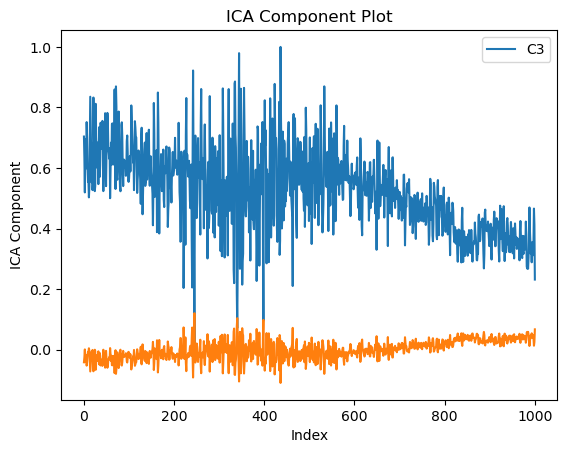

In [28]:
from sklearn.decomposition import FastICA

channel='C3'

print(normalized_df[[channel]])
ica = FastICA(n_components=1)
ica_result = ica.fit_transform(normalized_df[[channel]])

ica_df = pd.DataFrame(ica_result, columns=['ICA'])

plt.figure()
normalized_df.plot(y=channel)

column_data = normalized_df[channel].values.reshape(-1, 1)

plt.plot(ica_df['ICA'])
plt.xlabel('Index')
plt.ylabel('ICA Component')
plt.title('ICA Component Plot')
plt.show()

>  it is expected that the main change would be **the amplitude reduction**. ICA aims to separate mixed signals into statistically independent components, but it **does not necessarily alter the morphology** or shape of the original signal significantly.

## Wavelet 

The Wavelet Transform decomposes a signal into different frequency bands and provides information about the temporal localization of each frequency component. By analyzing the wavelet coefficients, you can gain insights into the signal's frequency content and how it varies over time.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Continuous_wavelet_transform.gif/300px-Continuous_wavelet_transform.gif)

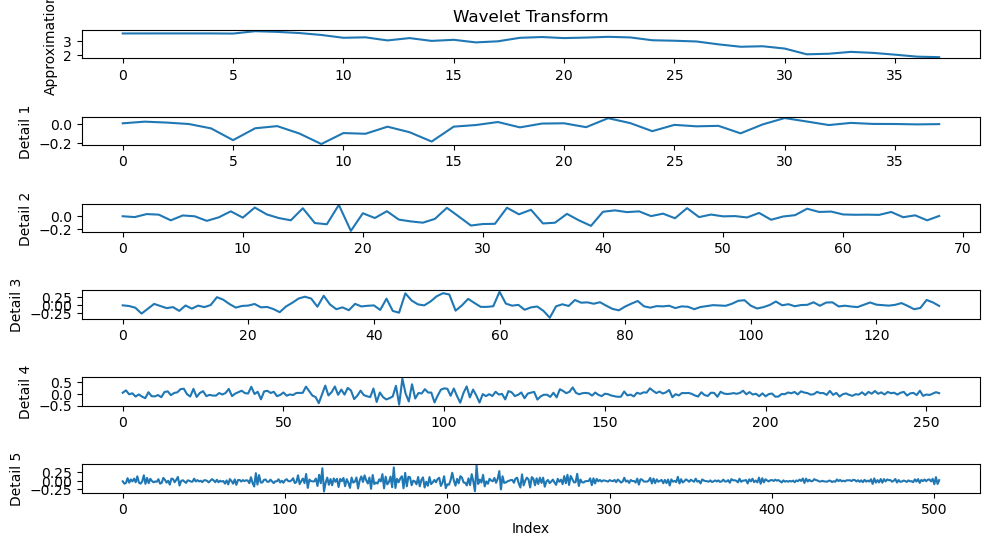

In [29]:
import pandas as pd
import pywt
import matplotlib.pyplot as plt

df=normalized_df
channel='C3'
# Apply Wavelet Transform
wavelet = 'db4'  # Wavelet type (choose according to your requirements)
level = 5  # Number of decomposition levels
coeffs = pywt.wavedec(df[channel], wavelet, level=level)

# Plot the approximation and detail coefficients
plt.figure(figsize=(10, 6))

# Approximation coefficients (low-frequency components)
plt.subplot(level + 2, 1, 1)
plt.plot(coeffs[0], label='Approximation')
plt.ylabel('Approximation')
plt.title('Wavelet Transform')

# Detail coefficients (high-frequency components)
for i in range(1, level + 1):
    plt.subplot(level + 2, 1, i + 1)
    plt.plot(coeffs[i], label=f'Detail {i}')
    plt.ylabel(f'Detail {i}')

plt.xlabel('Index')
plt.tight_layout()
plt.show()

The component with the highest **signal energy** may correspond to the main signal of interest

0


Text(0.5, 1.0, 'Original Signal vs. Optimal Wavelet Decomp. Component')

<Figure size 640x480 with 0 Axes>

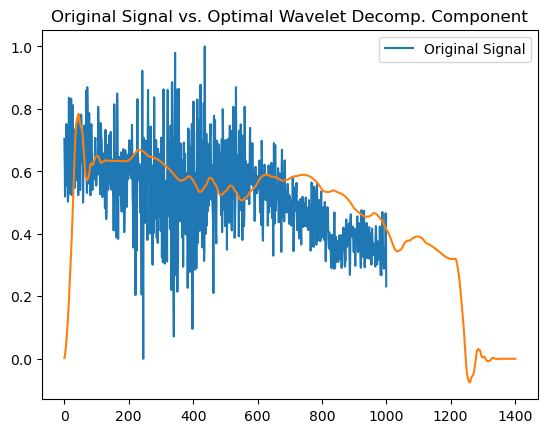

In [30]:
# Compute energy of each component
energies = [sum(comp ** 2) for comp in coeffs]

# Find the index of the component with the highest energy
max_energy_index = energies.index(max(energies))
print(max_energy_index)

# Select the component with the highest energy as the original signal
original_signal = coeffs[max_energy_index]



#    here I align the x axis due to the downsampling that occurs during the wavelet decomposition process.
#    In wavelet decomposition, as you go to higher levels, the signal is typically subsampled by a factor of 2 at each level.
#    This downsampling results in a reduced number of samples at each level compared to the original signal.
chosen = pywt.upcoef('a', original_signal, wavelet, level=level)   


plt.figure()
normalized_df.plot(y=channel,label='Original Signal')
 
plt.plot(chosen, label='Upsampled Approximation Coefficients')
plt.title('Original Signal vs. Optimal Wavelet Decomp. Component')

### Get the data

Let's choose the STD as the metric and form the events the way we want them!

In [31]:

neutral=np.array(model.get_analysis_timestamps()['neutral'])
end=np.array(model.get_analysis_timestamps()['end'])

print('\n\n Shape of neutrals:     ', neutral.shape )
print('\n Shape of ends:           ', end.shape )




 Shape of neutrals:      (34,)

 Shape of ends:            (29,)


/tmp/ipykernel_32/2818343103.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  neutral=np.array(model.get_analysis_timestamps()['neutral'])
/tmp/ipykernel_32/2818343103.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  end=np.array(model.get_analysis_timestamps()['end'])


In [32]:
min_std_columns = []

# Iterate over the arrays
for arr in neutral:
    # Calculate the standard deviation along the columns
    std_values = np.std(arr, axis=0)
    
    # Find the index of the column with the minimum standard deviation
    min_std_index = np.argmin(std_values)
    
    # Extract the column with the minimum standard deviation
    min_std_column = arr[:, min_std_index]
    
    # Append the extracted column to the list
    min_std_columns.append(min_std_column)
    
    
#          Normalise them

normalized_events = []

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Iterate over the extracted columns
for col in min_std_columns:
    # Reshape the column to a 2D array (required by MinMaxScaler)
    col_2d = col.reshape(-1, 1)
    
    # Normalize the column using MinMaxScaler
    normalized_col = scaler.fit_transform(col_2d)
    
    # Flatten the normalized column back to 1D
    normalized_col = normalized_col.flatten()
    
    # Append the normalized column to the list
    normalized_events.append(normalized_col)
    
train_neutrals= normalized_events

print('\nWe have neutral events: ', len(train_neutrals))



#    SAME FOR ENDS

min_std_columns = []

# Iterate over the arrays
for arr in end:
    # Calculate the standard deviation along the columns
    std_values = np.std(arr, axis=0)
    
    # Find the index of the column with the minimum standard deviation
    min_std_index = np.argmin(std_values)
    
    # Extract the column with the minimum standard deviation
    min_std_column = arr[:, min_std_index]
    
    # Append the extracted column to the list
    min_std_columns.append(min_std_column)
    
        
normalized_events = []

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Iterate over the extracted columns
for col in min_std_columns:
    # Reshape the column to a 2D array (required by MinMaxScaler)
    col_2d = col.reshape(-1, 1)
    
    # Normalize the column using MinMaxScaler
    normalized_col = scaler.fit_transform(col_2d)
    
    # Flatten the normalized column back to 1D
    normalized_col = normalized_col.flatten()
    
    # Append the normalized column to the list
    normalized_events.append(normalized_col)
    
train_ends= normalized_events

print('\nWe have end events: ', len(train_ends))


We have neutral events:  34

We have end events:  29


Visualise one random neutral and one random end state to obseve any possible differences

Text(0.5, 1.0, 'Random End Event')

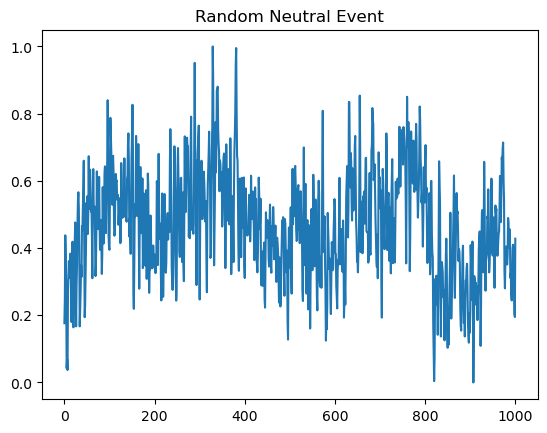

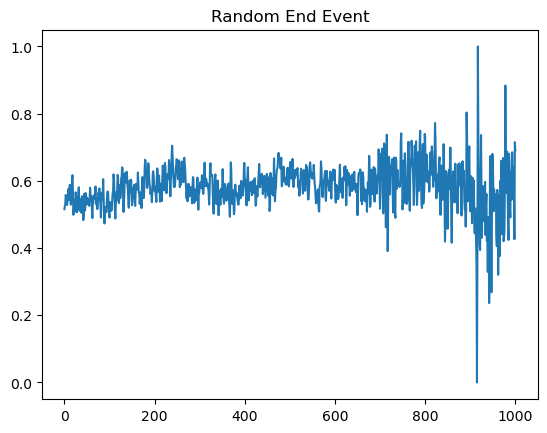

In [33]:
# plot 2 random states epochs

plt.figure()
plt.plot(train_neutrals[10])
plt.title('Random Neutral Event')

plt.figure()
plt.plot(train_ends[10])
plt.title('Random End Event')

let's now see if a machine can see any difference rather than the human eye which is the whole point of Machine Learning's classification

                                                Event    Label
0   [0.4674301194434065, 0.5813323482329622, 0.852...  neutral
1   [0.4185902080530006, 0.2793706655625705, 0.297...  neutral
2   [0.48974991950198543, 0.46313190941290117, 0.5...  neutral
3   [0.5406057357276879, 0.5265344411685859, 0.481...  neutral
4   [0.7306052855924889, 0.7667984189723285, 0.981...  neutral
..                                                ...      ...
58  [0.5531286894922971, 0.5088547815820448, 0.567...     ends
59  [0.5750088662962725, 0.37321196358907116, 0.29...     ends
60  [0.9617984593617308, 0.7440653985222525, 0.530...     ends
61  [0.11550745209368296, 0.11293470546486883, 0.2...     ends
62  [0.5306973640306865, 0.5266933600266839, 0.253...     ends

[63 rows x 2 columns]
                                                Event    Label  Event_Size
0   [0.4674301194434065, 0.5813323482329622, 0.852...  neutral        1001
1   [0.4185902080530006, 0.2793706655625705, 0.297...  neutral        1

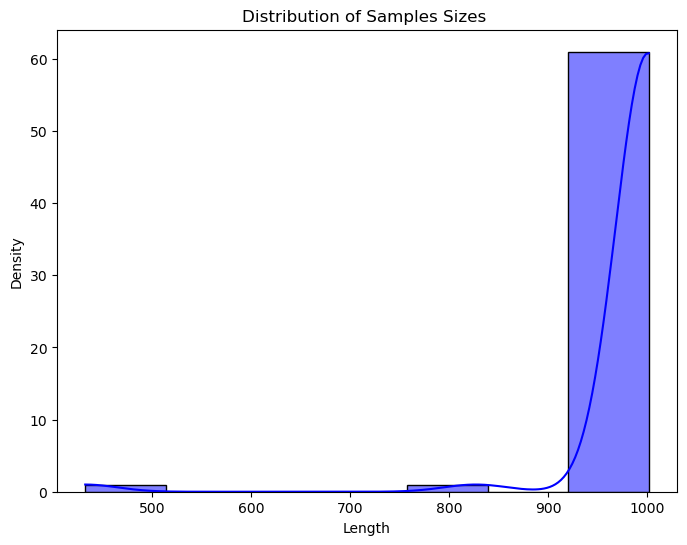

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

# lets put the in a dataframe
df_neutrals = pd.DataFrame({'Event': train_neutrals, 'Label': 'neutral'})
df_ends = pd.DataFrame({'Event': train_ends, 'Label': 'ends'})

# Concatenate the DataFrames
selected_samples = pd.concat([df_neutrals, df_ends], ignore_index=True)

# Print the DataFrame
print(selected_samples)


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11
# Some events have 1002 points for some reason so we have to make them all same size

# Print the size of each event
selected_samples['Event_Size'] = selected_samples['Event'].apply(len)
print(selected_samples)
sample_sizes = selected_samples['Event'].apply(len)
distribution = sample_sizes.value_counts().reindex(range(min(sample_sizes), max(sample_sizes) + 1), fill_value=0)

# Print the distribution of sample sizes
print("Distribution of Sample Sizes:")
print(distribution)



plt.figure(figsize=(8, 6))
sns.histplot(sample_sizes, kde=True, color='blue', edgecolor='black')

# Set labels and title
plt.xlabel('Length')
plt.ylabel('Density')
plt.title('Distribution of Samples Sizes ')

# Display the plot
plt.show()




In [ ]:
###         !!!! Keep ONLY Samples of size 1001

filtered_samples = selected_samples[selected_samples['Event'].apply(len) == 1001].reset_index(drop=True)



# Shuffle the DataFrame
samples = filtered_samples.sample(frac=1, random_state=42).reset_index(drop=True)

print(samples)

In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np

# Extract features and labels from the DataFrame
X = np.array(samples['Event'].tolist())
y = np.array(samples['Label'].tolist())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM model
svm_model = SVC()

# Train the SVM model
svm_model.fit(X_train, y_train)

# Evaluate the trained model on the test set
accuracy = svm_model.score(X_test, y_test)

print("Accuracy:", accuracy)


## Thoughts

The accuracy is pretty bad ... I will try to use other classifiers

The following was created by ChatGPT <3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the classifiers
classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'MLPClassifier': MLPClassifier()
}

# Train and evaluate the classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print the results
for name, accuracy in results.items():
    print(f'{name} Accuracy: {accuracy}')

# Plot the confusion matrices
plt.figure(figsize=(12, 8))
for i, (name, clf) in enumerate(classifiers.items(), 1):
    ax = plt.subplot(2, 4, i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [ ]:
classifiers = [
    SVC(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(),
    MLPClassifier()
]

# Train and evaluate each classifier
accuracies = []
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the accuracies
classifiers_names = ['SVM', 'Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors', 'Naive Bayes', 'Logistic Regression', 'MLPClassifier']
plt.figure(figsize=(8, 6))
plt.bar(classifiers_names, accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()
